In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%aimport simulation
%aimport mathf
%aimport util
%aimport inference
%aimport graph
%aimport hyper
%aimport seq

In [7]:
import os.path
from datetime import datetime
import numpy as np
from scipy import stats
from scipy import linalg
from scipy.io import loadmat, savemat
from scipy.linalg import orth
from numpy.linalg import norm
from numpy import dstack, rollaxis
from sklearn.decomposition.factor_analysis import FactorAnalysis
import h5py

import simulation, util, inference, graph, hyper, seq
from mathf import ichol_gauss, subspace
from util import rad2deg, rotate, add_constant

# plot setting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from matplotlib import colors
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.patches import FancyBboxPatch
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import set_matplotlib_formats
import seaborn as sns

In [3]:
sns.set_style("white")
PLDScolor = sns.xkcd_rgb["pale red"]
GPFAcolor =  sns.xkcd_rgb["medium green"]
vLGPcolor = sns.xkcd_rgb["denim blue"]

samplepath = os.path.expanduser("~/data/sample")
outputpath = os.path.expanduser("~/data/output")

In [10]:
Graf_Sample = [h5py.File(os.path.join(samplepath, 'Graf_1.mat'), 'r')]

In [16]:
y = np.transpose(Graf_Sample[0]['y'], axes=(2, 1, 0))

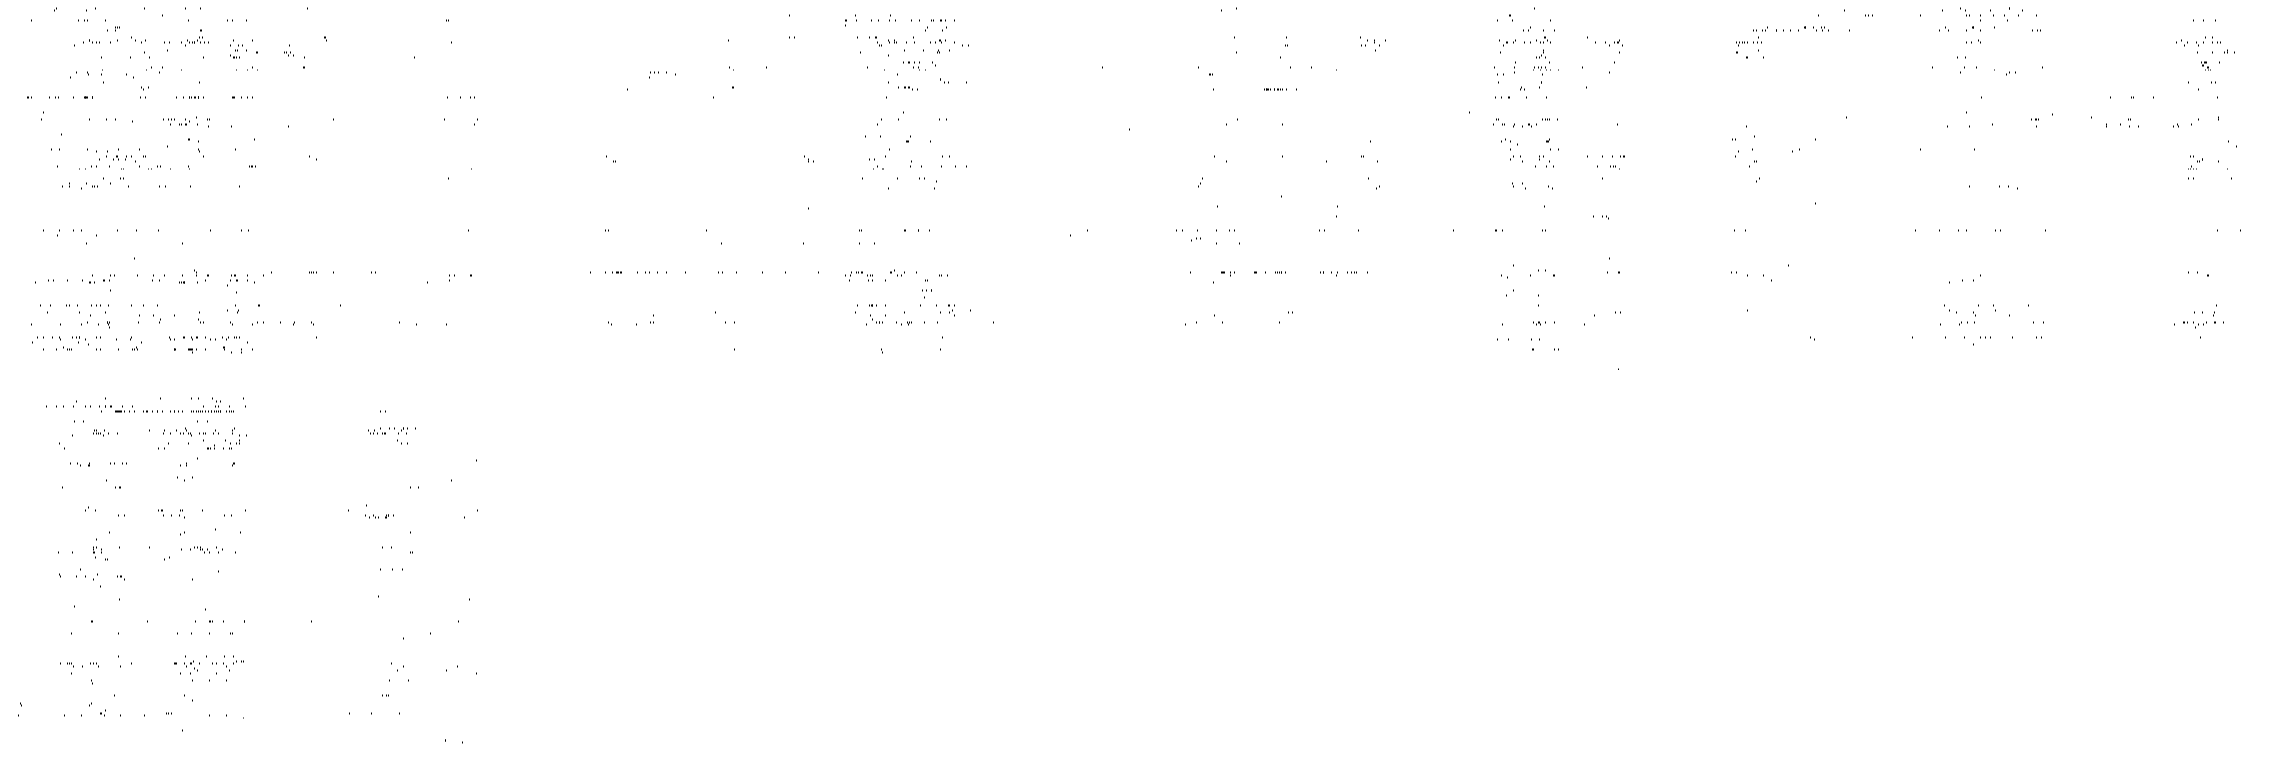

In [18]:
graph.rasterplot(y[:5, :, :])

In [21]:
sigma = np.full(3, fill_value=1.0)
omega = np.full(3, fill_value=1e-5)
result = inference.fit(y[:5, :], ['spike'] * y.shape[-1], sigma, omega, lag=0, rank=100, 
                                   niter=100, tol=1e-5, verbose=True, hyper=True)


Inference starts.
[1], posterior elapsed: 0.94, parameter elapsed: 9.92, ELBO: -714682.5197, LL: -695099.4320
[2], posterior elapsed: 0.93, parameter elapsed: 10.52, ELBO: -278243.2428, LL: -258992.9284
[3], posterior elapsed: 0.93, parameter elapsed: 10.05, ELBO: -118817.4124, LL: -99589.1792
[4], posterior elapsed: 0.96, parameter elapsed: 9.92, ELBO: -61164.9638, LL: -41924.7765
sigma: [ 1.  1.  1.] 
omega: [  1.00967875e-05   1.00967875e-05   1.00967875e-05]
[5], posterior elapsed: 0.92, parameter elapsed: 10.75, ELBO: -40800.8217, LL: -21557.6831
[6], posterior elapsed: 1.17, parameter elapsed: 10.06, ELBO: -33877.7879, LL: -14650.3616
[7], posterior elapsed: 0.91, parameter elapsed: 10.15, ELBO: -31591.9186, LL: -12367.7208
[8], posterior elapsed: 0.98, parameter elapsed: 9.85, ELBO: -30789.8830, LL: -11549.0183
[9], posterior elapsed: 0.94, parameter elapsed: 10.28, ELBO: -30476.9956, LL: -11206.9419
sigma: [ 1.  1.  1.] 
omega: [  1.06034856e-05   1.06034856e-05   1.06034856e-